 Once we have got the data, we can train a classifier to predict the positive or negative of the lncRNA.
 The total workflow of this section is as follows,
 + Normalization
 + Train test splitting
 + Parameter tuning and classifier training with over sampling
 + Cross validation

 Code:

In [0]:
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from imblearn.over_sampling import SMOTE
import warnings

def KfoldAUC(estimator, data, targets, cv, seed):
    Stratified_folder = StratifiedKFold(n_splits=cv, random_state=seed)
    FolderRes = Stratified_folder.split(data, targets)

    data = StandardScaler().fit_transform(data)

    # Get each k-fold results
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for train_index, test_index in FolderRes:
        # Original result for each fold
        X_train = data[train_index, :]
        y_train = targets[train_index]

        X_test = data[test_index, :]
        y_test = targets[test_index]
        # For each fold, resample the training one
        resampler = SMOTE(kind='svm', random_state=seed)
        X_res, y_res = resampler.fit_resample(X_train, y_train)

        clf = estimator
        clf.fit(X_res, y_res)

        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    return mean_auc


# Prepare xgb for bayes opt
def xgb_cv(n_estimator, max_depth, learning_rate, col_bytree, gamma, subsample, data, targets):
    estimator = XGBClassifier(n_estimators=n_estimator, 
                    max_depth=max_depth, 
                    learning_rate=learning_rate, 
                    colsample_bytree=col_bytree, 
                    gamma=gamma, 
                    subsample=subsample)
    # cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=10)
    cval = KfoldAUC(estimator, data, targets, cv=10, seed=442)
    return cval

def optimize_xgb(data, targets):
    """Apply Bayesian Optimization to Xgb parameters."""

    def xgb_crossval(n_estimators, max_depth, learning_rate, colsample_bytree, gamma, subsample):
        return xgb_cv(n_estimator = int(n_estimators), 
                    max_depth = int(max_depth), 
                    learning_rate = learning_rate, 
                    col_bytree = colsample_bytree,
                    gamma = gamma, 
                    subsample = subsample,
                    data=data, 
                    targets=targets)

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={'n_estimators': (10, 2000),
            'max_depth': (3, 10),
            'learning_rate': (0.01, 0.3),
            'colsample_bytree': (0.7, 1),
            'gamma': (0, 0.05),
            'subsample': (0.7, 1)},
        random_state=442)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        optimizer.maximize(init_points=5, n_iter=15, acq='ei')

    return optimizer

if __name__ == "__main__":
    # Load Data
    X = pd.read_csv("ProcessedData/LapScoreValid_Merged.csv")
    y = np.loadtxt("ProcessedData/TrainingLabel.txt", dtype = int)

    
    OptRes = optimize_xgb(X, y)
    print("Final result:", OptRes.max)


 The final tuning results is colsample_bytree = 0.7, gamma = 0.015, learning_rate = 0.01, max_depth = 10, n_estimators = 800 and subsample=0.99.

 Then we use cross validation to validate the performance of this classifier.
 Code:

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Start calculating AUC for each fold:
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
Ploting!


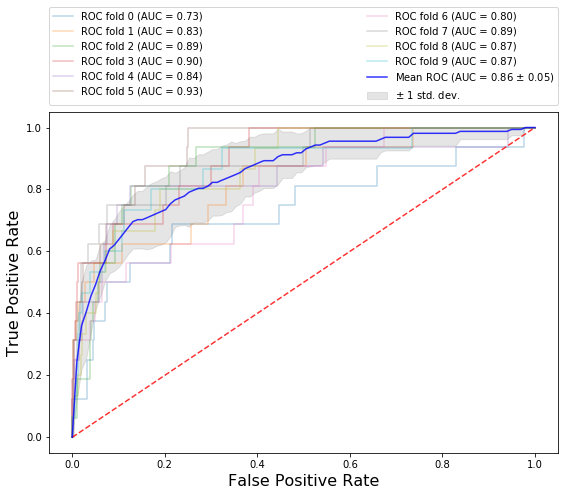

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

def GetFoldResult(data, targets, cv, seed):
    Stratified_folder = StratifiedKFold(n_splits=cv, random_state=seed)
    FolderRes = Stratified_folder.split(data, targets)

    data = StandardScaler().fit_transform(data)

    # Get each k-fold results
    FoldXtrain = []
    FoldXtest = []
    Foldytrain = []
    Foldytest = []

    for train_index, test_index in FolderRes:
        # Original result for each fold
        X_train = data[train_index, :]
        y_train = targets[train_index]

        X_test = data[test_index, :]
        y_test = targets[test_index]
        # For each fold, resample the training one
        resampler = SMOTE(kind='svm', random_state=seed)
        X_res, y_res = resampler.fit_resample(X_train, y_train)

        FoldXtrain.append(X_res)
        Foldytrain.append(y_res)
        FoldXtest.append(X_test)
        Foldytest.append(y_test)

    return FoldXtrain, FoldXtest, Foldytrain, Foldytest

def GetCVScore(X_trainList, X_testList, y_trainList, y_testList, estimator, cv):
    print ("=======================\nStart calculating AUC for each fold:")
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprlist = []
    fprlist = []

    for i in range(cv):
        X_train = X_trainList[i]
        y_train = y_trainList[i]

        X_test = X_testList[i]
        y_test = y_testList[i]

        clf = estimator
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        # ROC 
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        fprlist.append(fpr)
        tprlist.append(tpr)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        print ("Fold {} done".format(i+1))
    
    print ("=======================")
    return fprlist, tprlist, tprs, aucs

def PlotROC(fprlist, tprlist, tprs, aucs, cvfold):
    print ("Ploting!")
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.figure(figsize=(8, 7))
    # Plot each fold
    for i in range(cvfold):
        plt.plot(fprlist[i], 
                tprlist[i], 
                alpha=0.3, 
                label = "ROC fold %d (AUC = %.2f)"%(i, aucs[i]))
    # Plot the chance
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.8)
    # Plot the mean one
    plt.plot(mean_fpr, 
            mean_tpr, 
            color='b', 
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), alpha=.8)
    # Plot the variances
    plt.fill_between(mean_fpr, 
                    tprs_lower, 
                    tprs_upper, 
                    color='grey', 
                    alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.tight_layout()

    return plt


if __name__ == "__main__":
    X = pd.read_csv("ProcessedData/LapScoreValid_Merged.csv")
    y = np.loadtxt("ProcessedData/TrainingLabel.txt", dtype = int)

    cv = 10
    seed = 442

    X_trainList, X_testList, y_trainList, y_testList = GetFoldResult(X, y, cv, seed)

    estimator = XGBClassifier(
            objective='binary:logistic', 
            colsample_bytree = 0.7, 
            gamma = 0.015, 
            learning_rate = 0.01, 
            max_depth = 10, 
            n_estimators = 800, 
            subsample=0.99
        )

    fprlist, tprlist, tprs, aucs = GetCVScore(X_trainList, X_testList, y_trainList, y_testList, estimator, cv)

    PlotROC(fprlist, tprlist, tprs, aucs, cv)
    plt.show()
